# Izračun točk

In [82]:
import pandas as pd
import re

In [83]:
benchmarks = pd.read_csv("benchmarks.csv", names=["name", "sudoku", "result", "time"])

In [84]:
def kind(sudoku):
    match = re.search("(?P<kind>\w+)-\d+\.sdk", sudoku)
    if match:
        return match.group("kind")


benchmarks["kind"] = benchmarks.sudoku.apply(kind)

In [85]:
fastest_time = (
    benchmarks[benchmarks.result == "CORRECT"]
    .groupby("sudoku")
    .min()
    .time.rename("fastest")
)

times_with_fastest = pd.merge(benchmarks[["sudoku"]], fastest_time, on="sudoku")

benchmarks["relative_time"] = benchmarks.time / times_with_fastest.fastest

## Točke za pravilnost

- 5 točk - 100% pravilno rešenih običajnih sudokujev
- 4 točke - ≥50% pravilno rešenih običajnih sudokujev
- 3 točke - >0% pravilno rešenih običajnih sudokujev
- 0-2 točki - odvisno od pravilnosti pomožnih funkcij - se določi ročno

In [86]:
number_of_correct = (
    benchmarks[(benchmarks.kind == "obicajni") & (benchmarks.result == "CORRECT")]
    .groupby("name")
    .size()
)

<AxesSubplot:xlabel='name'>

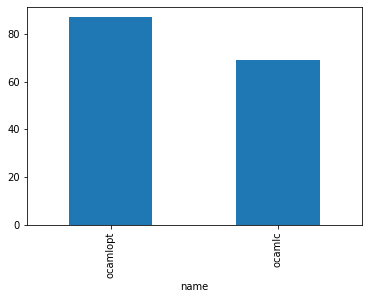

In [87]:
number_of_correct.sort_values(ascending=False).plot.bar()

In [88]:
total = len(set(benchmarks[benchmarks.kind == "obicajni"].sudoku))


def tocke_za_pravilnost(correct):
    if correct == total:
        return 5
    elif correct / total >= 0.5:
        return 4
    else:
        # če se vrednost pojavi, je moral biti vsaj en pravilen
        return 3

In [89]:
number_of_correct.apply(tocke_za_pravilnost)

name
ocamlc      4
ocamlopt    4
dtype: int64

## Točke za hitrost

In [90]:
speed_benchmarks = benchmarks[
    (benchmarks.kind == "obicajni") & ~pd.isna(benchmarks.relative_time)
]

<AxesSubplot:title={'center':'relative_time'}, xlabel='name'>

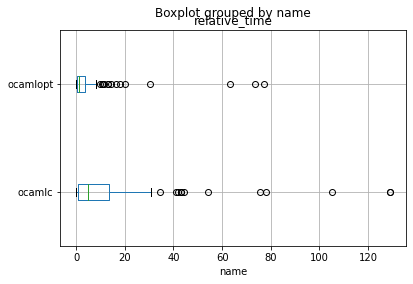

In [92]:
speed_benchmarks.boxplot("relative_time", by="name", vert=False)

name
ocamlc      3.155319
ocamlopt    1.000000
Name: relative_time, dtype: float64

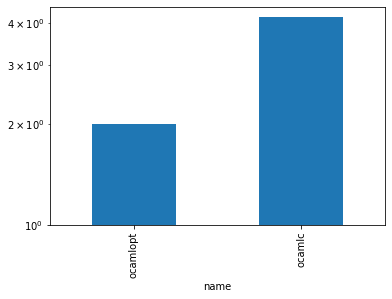

In [93]:
mean_relative_times = speed_benchmarks.groupby("name").mean().relative_time
min_relative_time = min(mean_relative_times)
speed = mean_relative_times / min(mean_relative_times)
speed.sort_values().plot.bar(log=True)
speed

## Točke za razširitve



In [94]:
extension_benchmarks = benchmarks[(benchmarks.result != "ERROR")]

In [95]:
extension_benchmarks.groupby(["name", "kind", "result"]).size().unstack()

,result,CORRECT,TIMEOUT,WRONG
name,kind,,,
ocamlc,obicajni,69,22,9
ocamlopt,obicajni,87,4,9


In [96]:
extension_benchmarks.groupby(["name", "kind"]).mean().relative_time

name      kind    
ocamlc    obicajni    16.334424
ocamlopt  obicajni     5.176789
Name: relative_time, dtype: float64